# Three methods of pre-processing data in chatbot development


To get a well-performing chatbot with accurate [intent classification and question-answering](https://intersog.com/blog/the-basics-of-qa-systems-from-a-single-function-to-a-pre-trained-nlp-model-using-python/), you usually need a massive amount of training data. Generally speaking, that data is collected from human inputs (dialogues and chats with the bot) and used to retrain the underlying model.

At the beginning of the chatbot development process, however, you may face the lack of training data, which results in low accuracy in intent classification. A few workarounds exist to solve this problem:

1. Pre-trained model.
2. Training data generator.
3. Crowdsource.

These three methods can greatly improve the NLU (Natural Language Understanding) classification training process in your chatbot development project. Below we demonstrate how methods may influence accuracy.

For this demo, we use [Rasa](https://rasa.com), an open-source conversational AI framework. You may need to install this framework with a few dependencies. The source code for this demo is available [here](https://github.com/interds/3-methods-of-nlu-data-pre-processing).

In [ ]:
!git clone https://github.com/interds/3-methods-of-nlu-data-pre-processing.git
%cd ./3-methods-of-nlu-data-pre-processing
!apt-get install python3-venv
!python -m venv --system-site-packages ./venv
!source ./venv/bin/activate
!pip install rasa[transformers]
!pip install -U ipython # fix create_prompt_application
!pip install pandas
!pip install chatette
!pip install transformers
!pip install tensorflow_datasets

### Initial model

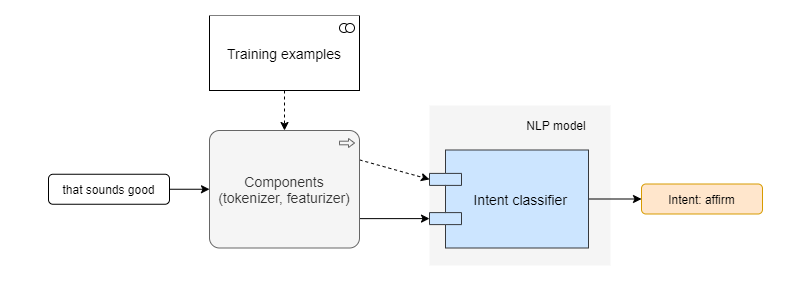

Rasa's boilerplate generated by 'rasa init' is enough to demonstrate the initial model in our chatbot development effort.

We train and evaluate the model with the following config:

```yaml
language: en
pipeline:
  - name: WhitespaceTokenizer
  - name: CountVectorsFeaturizer
  - name: CountVectorsFeaturizer
    analyzer: "char_wb"
    min_ngram: 1
    max_ngram: 4
  - name: DIETClassifier
    epochs: 100
```

In [ ]:
!rasa train -c config-simple.yml --fixed-model-name simple --quiet

Training Core model...
2020-06-22 20:46:54.811928: E tensorflow/stream_executor/cuda/cuda_driver.cc:351] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Core model training completed.
Training NLU model...
/usr/local/lib/python3.6/dist-packages/rasa/utils/common.py:363: UserWarning: You specified 'DIET' to train entities, but no entities are present in the training data. Skip training of entities.
NLU model training completed.
Your Rasa model is trained and saved at '/content/models/simple.tar.gz'.


In [ ]:
!rasa test nlu -c config-simple.yml -u test_data.md -m models/simple.tar.gz --out results/simple --quiet

report = pd.read_json("results/simple/intent_report.json", orient="values")
simple_f1 = report["weighted avg"]["f1-score"]
data = [["simple", simple_f1]]
pd.DataFrame(data, columns=["Model", "F1-sore"])

2020-06-22 21:00:29.891699: E tensorflow/stream_executor/cuda/cuda_driver.cc:351] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
100% 14/14 [00:00<00:00, 108.22it/s]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Model,F1-sore
0,simple,0.614286


*Expected F1-score = 0.614286*

In test data we have lexically different examples from the ones in training data, so it is expected that our simple pipeline doesn't recognize them properly:

```md
## intent:affirm
- alright
- sure
- ok
```

## 1. Pre-trained model

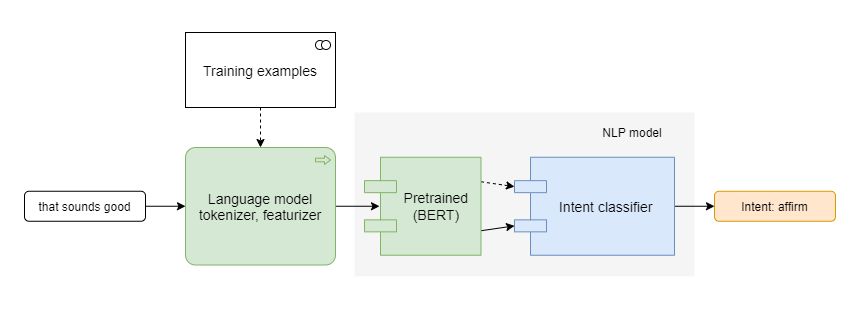

The pre-trained language model can be used for NLU tasks without any task-specific change to the model architecture. Pre-trained models have an ability to continue pre-training on custom data, strarting from some checkpoint.

This process is compute-intensive and requires a massively parallel compute infrastructure. The training of such general models on task-specific training data, called Fine-tuning, is far less computationally demanding and used more often. Well-known examples of similar models are Google’s [BERT](https://github.com/google-research/bert), [XLNet](https://github.com/zihangdai/xlnet) and OpenAI’s [GPT-2](https://openai.com/blog/better-language-models/).

Let's find how the pre-trained model can help with intent classification. We use the following config:

```yaml
language: en
pipeline:
  - name: HFTransformersNLP
    model_weights: "bert-base-uncased"
    model_name: "bert"
  - name: LanguageModelTokenizer
  - name: LanguageModelFeaturizer
  - name: DIETClassifier
    epochs: 100
```

In [ ]:
!rasa train -c config-bert.yml --fixed-model-name bert --quiet

Core stories/configuration did not change. No need to retrain Core model.
Training NLU model...
Downloading: 100% 232k/232k [00:00<00:00, 1.93MB/s]
Downloading: 100% 433/433 [00:00<00:00, 299kB/s]
Downloading: 100% 536M/536M [00:08<00:00, 63.4MB/s]
2020-06-22 20:48:18.155538: E tensorflow/stream_executor/cuda/cuda_driver.cc:351] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/usr/local/lib/python3.6/dist-packages/rasa/utils/common.py:363: UserWarning: You specified 'DIET' to train entities, but no entities are present in the training data. Skip training of entities.
NLU model training completed.
Your Rasa model is trained and saved at '/content/models/bert.tar.gz'.


In [ ]:
!rasa test nlu -c config-bert.yml -u test_data.md -m models/bert.tar.gz --out results/bert --quiet

report = pd.read_json("results/bert/intent_report.json", orient="values")
bert_f1 = report["weighted avg"]["f1-score"]
data = [["simple", simple_f1], ["bert", bert_f1]]
pd.DataFrame(data, columns=["Model", "F1-sore"])

2020-06-22 20:49:03.856455: E tensorflow/stream_executor/cuda/cuda_driver.cc:351] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
100% 14/14 [00:03<00:00,  4.04it/s]


,Model,F1-sore
0,simple,0.614286
1,bert,0.930612


*Expected F1-score = 0.930612*

As we see, without modification of training data, usage of the pre-trained BERT model improves the accuracy of intent detection. This happens because the model already has knowledge about word's synonyms, which helped to recognize matches.

### Fine-tuning your AI chatbot

To perform Fine-tuning of the chatbot development model, follow the instructions on [Sentence (and sentence-pair) classification tasks](https://github.com/google-research/bert#sentence-and-sentence-pair-classification-tasks) from Google's BERT repository. In general, you need to download some text corpus or to convert your text data to BERT's input format, then run Fine-tuning command. You can prepare a new model with the following script:

In [ ]:
from transformers import TFBertModel, BertTokenizer

model = TBertModel.from_pretrained("bert-base-uncased")
model.save_pretrained("./model-fine-tuned-1/")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
tokenizer.save_pretrained("./model-fine-tuned-1/")

Follow the instructions for Fine-tuning. An example of Fine-tuning Bert model on the MRPC classification task is given below:

```sh
export BERT_BASE_DIR=/path/to/bert/uncased_L-12_H-768_A-12
export GLUE_DIR=/path/to/glue

python run_classifier.py \
  --task_name=MRPC \
  --do_train=true \
  --do_eval=true \
  --data_dir=$GLUE_DIR/MRPC \
  --vocab_file=$BERT_BASE_DIR/vocab.txt \
  --bert_config_file=$BERT_BASE_DIR/bert_config.json \
  --init_checkpoint=$BERT_BASE_DIR/bert_model.ckpt \
  --max_seq_length=128 \
  --train_batch_size=32 \
  --learning_rate=2e-5 \
  --num_train_epochs=3.0 \
  --output_dir=/tmp/mrpc_output/
```

When ready, the model from resulting folder can be used in your pipeline and it should have higher F1-score than original one.

Here is another tuning example from the [transformers](https://github.com/huggingface/transformers) library:

In [ ]:
import tensorflow as tf
import tensorflow_datasets
from transformers import *

# Load dataset, tokenizer, model from pretrained model/vocabulary
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')
data = tensorflow_datasets.load('glue/mrpc')

# Prepare dataset for GLUE as a tf.data.Dataset instance
train_dataset = glue_convert_examples_to_features(data['train'], tokenizer, max_length=128, task='mrpc')
valid_dataset = glue_convert_examples_to_features(data['validation'], tokenizer, max_length=128, task='mrpc')
train_dataset = train_dataset.shuffle(100).batch(32).repeat(2)
valid_dataset = valid_dataset.batch(64)

# Prepare training: Compile tf.keras model with optimizer, loss and learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Train and evaluate using tf.keras.Model.fit()
history = model.fit(train_dataset, epochs=2, steps_per_epoch=115,
                    validation_data=valid_dataset, validation_steps=7)

# Load the TensorFlow model in PyTorch for inspection
model.save_pretrained('./model-fine-tuned-2/')

## 2. Training data generator

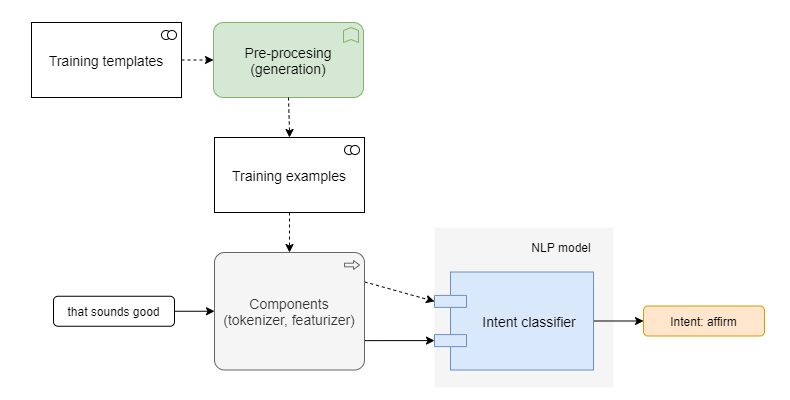

To quickly get more training data for NLU task, you can use a training data generator. It is a program which takes templates and generates a lot of examples for model training. Well-known generators are [Chatito](https://github.com/rodrigopivi/Chatito) (in Node.js) and [Chatette](https://github.com/SimGus/Chatette) (in Python).

Instead of writing examples directly, you write one or several template files in a specific format, then run the generator which parses templates and outputs ready-to-use examples. To train a powerful model, you need to use the generator not just for intent detection, but more for named entity recognition.

Let's generate samples for our easy intent with Chatette. Write a template file "affirm.chatette" with the following content:

```
~[yes]
  yes
  indeed
  of course
  that sounds good
  correct
  got it
  alright
  sure
  ok


~[thanks]
    thanks
    thank you 

%[greet](training:100)
    ~[yes][,?] ~[thanks?]
```

Next, generate an nlu file.

In [ ]:
!python -m chatette -f -s YZkEus -a rasa-md -o results data-generate/affirm.chatette
!cp results/train/output.md data-generate/nlu/affirm.md

Executing Chatette with seed 'YZkEus'.
[DBG] Parsing file: /content/data-generate/affirm.chatette
[DBG] Generating training examples...
[DBG] Generating testing examples...
[DBG] Generation over


Next, we train and evaluate our simple model with just generated data.

In [ ]:
!rasa train -c config-simple.yml --data data-generate --fixed-model-name generated --quiet

Core stories/configuration did not change. No need to retrain Core model.
Training NLU model...
2020-06-22 20:49:26.699066: E tensorflow/stream_executor/cuda/cuda_driver.cc:351] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/usr/local/lib/python3.6/dist-packages/rasa/utils/common.py:363: UserWarning: You specified 'DIET' to train entities, but no entities are present in the training data. Skip training of entities.
NLU model training completed.
Your Rasa model is trained and saved at '/content/models/generated.tar.gz'.


In [ ]:
!rasa test nlu -c config-simple.yml -u test_data.md -m models/generated.tar.gz --out results/generated --quiet

report = pd.read_json("results/generated/intent_report.json", orient="values")
generated_f1 = report["weighted avg"]["f1-score"]
data = [["simple", simple_f1], ["generated", generated_f1]]
pd.DataFrame(data, columns=["Model", "F1-sore"])

2020-06-22 21:06:57.539434: E tensorflow/stream_executor/cuda/cuda_driver.cc:351] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
100% 14/14 [00:00<00:00, 110.23it/s]


,Model,F1-sore
0,simple,0.614286
1,generated,1.000000


*Expected F1-score = 1.000000*

As we see in this case, we improve accuracy by generating examples, without modifying the model config. Now, imagine that having 3 aliases with 10 examples each, like

```
%[example]
    ~[alias1] ~[alias2] ~[alias3]
```

you can generate 1000 training samples!

With many intents used to build your chatbot, the intent errors count grows. To fix this you need more examples, especially for lexically close intents. And the training data generator is an easy way to provide them.

## 3. Crowdsource

To get more training data of high quality, you can outsource jobs to distributed workers, using [Amazon Mechanical Turk](), [Microworkers](https://www.microworkers.com/) or [Clickworker](https://www.clickworker.com/) platforms.

MTurk is well-suited to take simple and repetitive tasks that need to be handled manually. In a short time and at a reduced cost, you can get human-written training data for your initial model to augment training data collection and ultimately accelerate [Python-based](https://intersog.com/blog/some-cool-things-you-can-do-with-python/) chatbot development.

## Key takeways

In this article, we have considered three ways to improve language model intent detection accuracy.

**The first one**, the Pre-trained model, is the most computation-heavy yet allows us to have fewer examples to perform training, without accuracy loss.

**The second one**, Training data generator, is the simplest method that still requires to write some templates in a specific language. It reduces the amount of text input and grows the number of available samples to train the model.

**The third one**, Crowdsource, gives the most accurate output written by humans, but typically involves an extra cost to put in place.